In [1]:
!pwd
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import sys
sys.executable

/c/Users/81908/jupyter_notebook/tf_2_work/04.image_relate/tf_image


'C:\\Users\\81908\\Anaconda3\\envs\\tfgpu\\python.exe'

# BigTransfer（BiT）
- https://blog.tensorflow.org/2020/05/bigtransfer-bit-state-of-art-transfer-learning-computer-vision.html

<br>

## Google Colab
- https://colab.research.google.com/drive/1RRPrGSE3-4DHdN6zBCGmJfIm2BVcxVHi

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import time

from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

import os
import pathlib

## ImageNetでfinetuningしたBitロードしてpredict

In [3]:
def preprocess_image(image):
    image = np.array(image)
    # reshape into shape [batch_size, height, width, num_channels]
    img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    image = tf.image.convert_image_dtype(img_reshaped, tf.float32)  
    return image


def load_image_from_url(url):
    """Returns an image with shape [1, height, width, num_channels]."""
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    image = preprocess_image(image)
    return image


# Load model fine-tuned on ImageNet
model_url = "https://tfhub.dev/google/bit/m-r50x1/ilsvrc2012_classification/1"
imagenet_module = hub.KerasLayer(model_url)

# Load image (image provided is CC0 licensed)
img_url = "https://p0.pikrepo.com/preview/853/907/close-up-photo-of-gray-elephant.jpg"
image = load_image_from_url(img_url)

# Run model on image
logits = imagenet_module(image)

logits

<tf.Tensor: shape=(1, 1000), dtype=float32, numpy=
array([[ 1.42605460e+00, -6.26688778e-01, -8.42166007e-01,
         1.21697164e+00,  2.53844261e+00,  2.54805303e+00,
         1.36401105e+00,  2.46093925e-02, -7.20751584e-01,
         2.66016603e+00, -1.54021585e+00, -8.96991909e-01,
        -8.60445976e-01,  7.36302376e-01, -1.32243987e-02,
        -8.78250778e-01, -9.99379456e-01, -2.89717942e-01,
        -9.97270823e-01, -7.82536864e-01, -1.21428736e-01,
         2.22873405e-01,  5.31880438e-01,  2.25119472e+00,
        -3.84564787e-01, -3.70407015e-01,  1.08468843e+00,
        -1.85174271e-01, -7.43333936e-01,  1.26299202e+00,
        -5.14345586e-01,  1.25777626e+00,  8.51604521e-01,
        -1.20586753e+00,  5.02414882e-01,  1.22681761e+00,
         8.23142827e-01,  8.35922182e-01,  1.93131208e-01,
         4.74942535e-01, -8.09844196e-01,  4.72832054e-01,
        -1.68356347e+00,  7.49640539e-03,  7.62324095e-01,
        -2.62576163e-01, -9.59635735e-01,  1.96579766e+00,
     

## 犬猫画像でBitのモデルをfinetuning
- BiT-HyperRule（BiTの推奨ハイパーパラメータ）は、0.003の初期学習率、運動量0.9、バッチサイズ512のSGDを使用します。微調整中に、学習率を30％、60％、90％で10倍に減衰させる
- lossは CategoricalCrossentropy or SparseCategoricalCrossentropy でないとlossがnanになる。。。
- tensorflow2.1では？保存したBitのモデルロードできない？モデルファイルからロードができなかった

Found 1000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


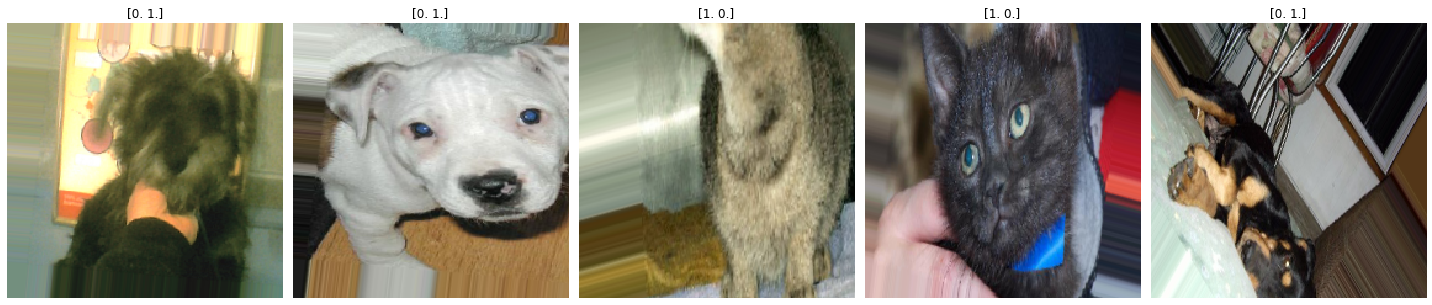

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

OUTPUT_DIR = r'D:\work\tmp\out_tf_image'

TRAIN_DIR = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\train'
VALID_DIR = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\validation'

IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 64
EPOCHS = 5
NUM_CLASSES = 2

def get_image_generator(train_IDG_options: dict):
    train_image_generator = ImageDataGenerator(**train_IDG_options) # Generator for our training data
    validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

    train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                               directory=TRAIN_DIR,
                                                               shuffle=True,
                                                               target_size=(IMG_SIZE, IMG_SIZE),
                                                               class_mode='categorical')
                                                               #class_mode='binary')

    valid_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                                    directory=VALID_DIR,
                                                                    shuffle=False,
                                                                    target_size=(IMG_SIZE, IMG_SIZE),
                                                                    class_mode='categorical')
                                                                    #class_mode='binary')
    
    return train_data_gen, valid_data_gen

train_IDG_options = {'rescale': 1.0/255.0, 
                     'width_shift_range': 0.15,
                     'height_shift_range': 0.15,
                     'horizontal_flip': True, 
                     'rotation_range': 45, 
                     'zoom_range': 0.5}
train_data_gen, valid_data_gen = get_image_generator(train_IDG_options)



def plot_images(images_arr: np.ndarray, y_onehots: np.ndarray):
    """
    ラベルをタイトルにしてnumpyの画像を並べて表示
    Args:
        images_arr:[5,hight,width,3]のnumpy画像
        y_onehots:[5,n]のラベル
    Usage:
        train_image_generator = ImageDataGenerator(rescale=1./255)
        train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,…)
        sample_training_images, y_onehots = next(train_data_gen)
        plot_images(sample_training_images[:5], y_onehots)
    """
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, y, ax in zip (images_arr, y_onehots, axes):
        ax.imshow(img)
        ax.set_title(y)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
sample_training_images, y_onehots = next(train_data_gen)
plot_images(sample_training_images[:5], y_onehots)

In [17]:
def get_base_cb(output_dir=OUTPUT_DIR, save_weights_only=True):
    """callbackの組み合わせ"""
    cb = []
    # 各エポックでval_lossが最小となるモデル保存
    cb.append(tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'bit_best_val_loss_w.h5'), monitor='val_loss', save_best_only=True, verbose=1, 
                                                 save_weights_only=save_weights_only))
    # 過学習の抑制 <early_stopping_pati>step続けてval_loss減らなかったら打ち切る
    cb.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=EPOCHS//2, verbose=1))
    return cb

In [19]:
class MyBiTModel(tf.keras.Model):
    """BiT with a new head."""

    def __init__(self, num_classes, module):
        super().__init__()

        self.num_classes = num_classes
        self.head = tf.keras.layers.Dense(num_classes, kernel_initializer='zeros')
        self.bit_model = module

    def call(self, images):
        # No need to cut head off since we are using feature extractor model
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)

    
def get_bit_model(num_classes):
    # TFHubからモデルロード
    model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
    module = hub.KerasLayer(model_url)
    model = MyBiTModel(num_classes=num_classes, module=module)
    return model
    

def train_bit(train_data_gen, valid_data_gen, num_classes=NUM_CLASSES, epochs=EPOCHS):
    """(ImageNet-21kで事前トレーニングされた)Bitでfinetuning"""
    model = get_bit_model(num_classes)
    
    # SCHEDULE_BOUNDARIES（指定step単位で学習率変える）で学習率1/10倍していく
    lr = 0.003
    SCHEDULE_BOUNDARIES = [200, 300, 400] #[200, 300, 400, 500]
    lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, values=[lr, lr*0.1, lr*0.001, lr*0.0001])
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

    #loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)  # onehotでないカテゴリーラベルのときのloss
    #loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)  # バイナリラベルのときのloss。これ使うとlossなぜかnanになる
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)  # onehotのカテゴリーラベルのときのloss
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    # Fine-tune model
    history = model.fit(train_data_gen, 
                        epochs=EPOCHS, 
                        validation_data=valid_data_gen, 
                        callbacks = get_base_cb()
                       )
    
    return history, model


history, model = train_bit(train_data_gen, valid_data_gen)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 16 steps, validate for 7 steps
Epoch 1/5
15/16 [===========================>..] - ETA: 1s - loss: 0.1387 - accuracy: 0.9391
Epoch 00001: val_loss improved from inf to 0.03355, saving model to D:\work\tmp\out_tf_image\bit_best_val_loss_w.h5
16/16 [==============================] - 22s 1s/step - loss: 0.1394 - accuracy: 0.9410 - val_loss: 0.0335 - val_accuracy: 0.9875
Epoch 2/5
15/16 [===========================>..] - ETA: 0s - loss: 0.0950 - accuracy: 0.9776
Epoch 00002: val_loss did not improve from 0.03355
16/16 [==============================] - 12s 742ms/step - loss: 0.0899 - accuracy: 0.9780 - val_loss: 0.0441 - val_accuracy: 0.9825
Epoch 3/5
15/16 [===========================>..] - ETA: 0s - loss: 0.0904 - accuracy: 0.9808
Epoch 00003: val_loss did not improve from 0.03355
16/16 [==============================] - 12s 732ms/step - loss: 0.0850 - accuracy: 0.9820 - val_loss: 0.1067 - val_accuracy: 0.9800
Epoch 00003: early stopping


In [26]:
# Save fine-tuned model as SavedModel
export_module_dir = os.path.join(OUTPUT_DIR, 'my_saved_bit_model')
tf.saved_model.save(model, export_module_dir)

# Load saved model
saved_module = hub.KerasLayer(export_module_dir, trainable=True)

INFO:tensorflow:Assets written to: D:\work\tmp\out_tf_image\my_saved_bit_model\assets


INFO:tensorflow:Assets written to: D:\work\tmp\out_tf_image\my_saved_bit_model\assets


ValueError: Signature name has to be specified for non-callable saved models (if not legacy Hub.Module).

In [ ]:
trained_module = hub.KerasLayer(saved_module)

# Load image (image provided is CC0 licensed)
img_url = "https://p0.pikrepo.com/preview/853/907/close-up-photo-of-gray-elephant.jpg"
image = load_image_from_url(img_url)

# Run model on image
logits = imagenet_module(image)

logits

In [20]:
model = get_bit_model(NUM_CLASSES)
model.load_weights(OUTPUT_DIR + '/bit_best_val_loss_w.h5')
#load_model = tf.keras.models.load_model(OUTPUT_DIR + '/bit_best_val_loss.h5', compile=False)

# モデル評価
test_loss, test_acc = model.evaluate(valid_data_gen)
print(test_loss, test_acc)

ValueError: You are trying to load a weight file containing 2 layers into a model with 1 layers.

In [24]:
def get_functional_model(model, input_shape=(IMG_SIZE, IMG_SIZE ,3)):
    """
    model.summary()でエラー避けるため、インスタンス化した「仮のモデル」をFunctional APIで生成する独自関数
    https://www.atmarkit.co.jp/ait/articles/2003/10/news016.html
    
    以下の書き方でもmodel.summary()出せるが、Output Shapeが表示されない
    model = MyModel()
    model.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH ,3))  # モデルのビルド
    model.summary()
    """
    x = tf.keras.layers.Input(shape=input_shape, name='layer_in')
    temp_model = tf.keras.Model(
        inputs=[x],
        outputs=model.call(x),  # ※サブクラス化したモデルの`call`メソッドを指定
        name='temp_model')  # 仮モデルにも名前付け
    return temp_model

f_model = get_functional_model(model)
f_model.summary()

Model: "temp_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_in (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
keras_layer_5 (KerasLayer)   (None, 2048)              23500352  
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 4098      
Total params: 23,504,450
Trainable params: 4,098
Non-trainable params: 23,500,352
_________________________________________________________________
